In [1]:
#!git clone https://github.com/chiggum/pyLDLE2.git

Cloning into 'pyLDLE2'...
remote: Enumerating objects: 1902, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 1902 (delta 87), reused 141 (delta 51), pack-reused 1716
Receiving objects: 100% (1902/1902), 801.25 MiB | 14.62 MiB/s, done.
Resolving deltas: 100% (837/837), done.
Updating files: 100% (102/102), done.


In [3]:
#!pip install multiprocess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00


In [1]:
import sys
sys.path.insert(0, './pyLDLE2/')

In [2]:
import numpy as np
from pyLDLE2 import util_, visualize_, datasets
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf, erfinv
from matplotlib import pyplot as plt
from scipy.stats import chi2

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [3]:
vis = visualize_.Visualize()

In [7]:
X, labelsMat, ddX = datasets.Datasets().disk_checkerboard_uniform(n=10000, noise=0.05)

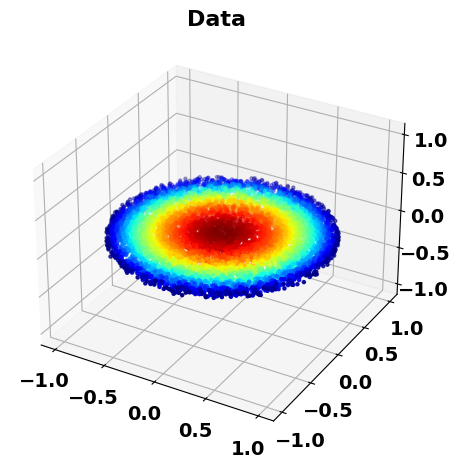

In [8]:
vis.data(X, ddX)

In [9]:
k_nn = 128
neigh_dist, neigh_ind = util_.nearest_neighbors(X, k_nn, metric='euclidean')

neigh_dist = neigh_dist[:,1:]
neigh_ind = neigh_ind[:,1:]

In [10]:
h_cand = np.sqrt(2)*neigh_dist[:,-1]/np.sqrt(chi2.ppf(0.99, df=2))
print(np.min(h_cand), np.median(h_cand), np.max(h_cand))
h = np.min(h_cand)
K = np.exp(-neigh_dist**2/h**2)

0.055253021371142096 0.06453014409795634 0.0990674314574932


In [11]:
n = X.shape[0]
source_ind = np.repeat(np.arange(n),neigh_ind.shape[1])
K = coo_matrix((K.flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))
ones_K_like = coo_matrix((np.ones(neigh_dist.shape).flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))

# symmetrize
K = K + K.T
ones_K_like = ones_K_like + ones_K_like.T
K.data /= ones_K_like.data

In [12]:
mu_hN_norm = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    temp = X-X[i,:][None,:]
    mu_hN_norm[i] = np.linalg.norm(K.getrow(i).dot(temp))

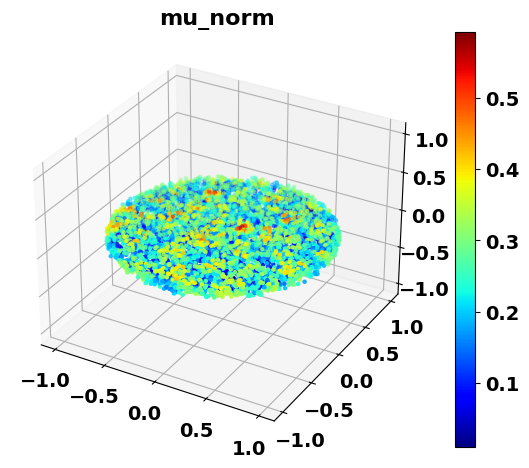

In [14]:
vis.data(X, mu_hN_norm, title='mu_norm', colorbar=True)

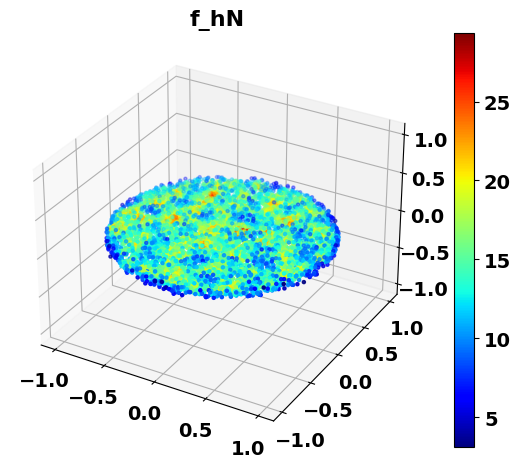

In [15]:
vis.data(X, np.array(K.sum(axis=1)).flatten(), title='f_hN', colorbar=True)

In [16]:
c_num = h*np.array(K.sum(axis=1)).flatten()/np.sqrt(np.pi)
c_denom = mu_hN_norm
c = c_num/(c_denom+1e-20)

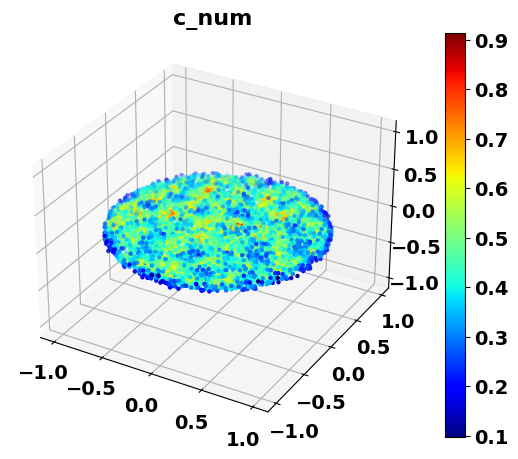

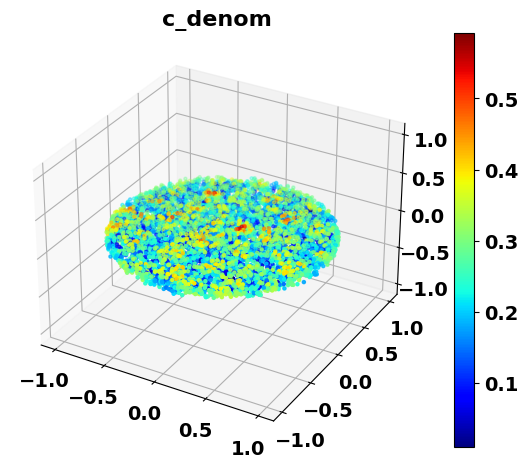

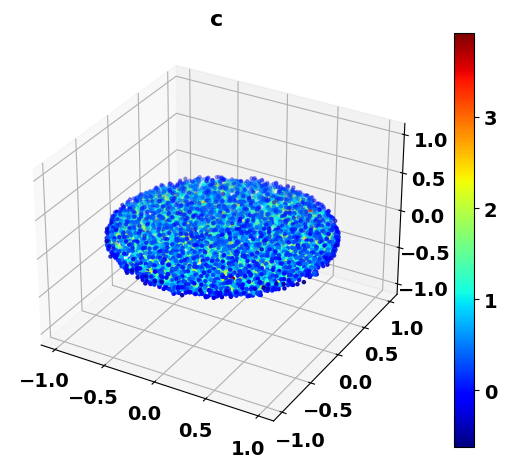

In [17]:
vis.data(X, c_num, title='c_num', colorbar=True)
vis.data(X, c_denom, title='c_denom', colorbar=True)
vis.data(X, np.log(c), title='c', colorbar=True)

In [18]:
def F(x):
    return c_denom*(1+erf(x/h))*np.exp(x**2/h**2)-c_num

def F_prime(x):
    return (c_denom/h)*(2/np.sqrt(np.pi) + 2*(1+erf(x/h))*np.exp(x**2/h**2)*x/h)

In [19]:
bx_init = h*np.sqrt(np.maximum(0, -np.log(2*c_denom+1e-30)+np.log(c_num+1e-30)))

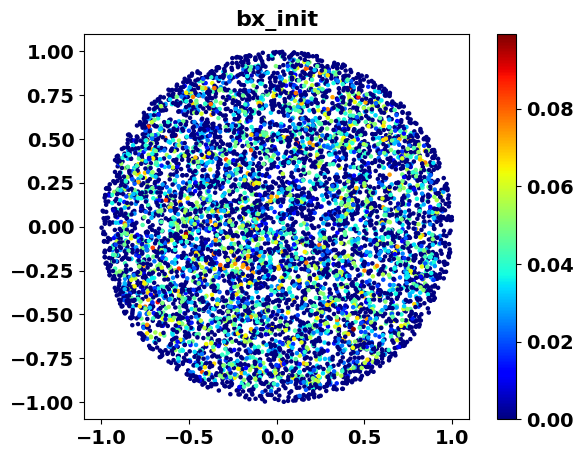

In [20]:
vis.data(X[:,:2], bx_init, title='bx_init', colorbar=True)

In [21]:
bx = optimize.newton(F, bx_init, F_prime, maxiter=10000)

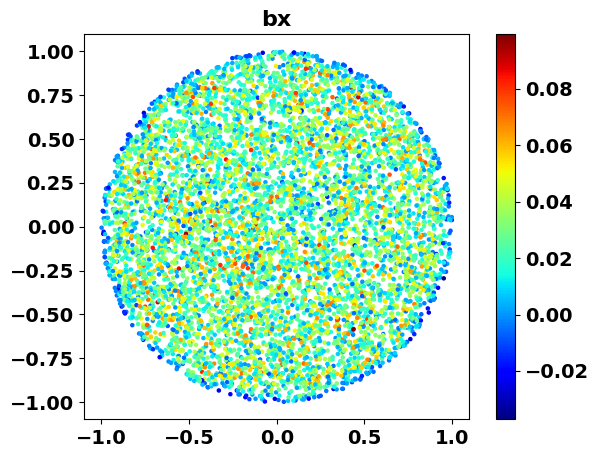

In [22]:
vis.data(X[:,:2], bx, title='bx', colorbar=True)

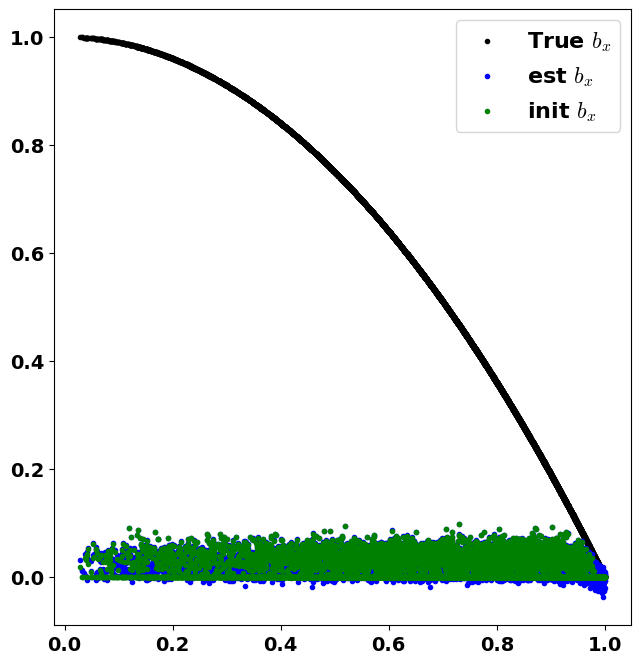

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx_init, color='g', label='init $b_x$')
plt.axis('image')
plt.legend()

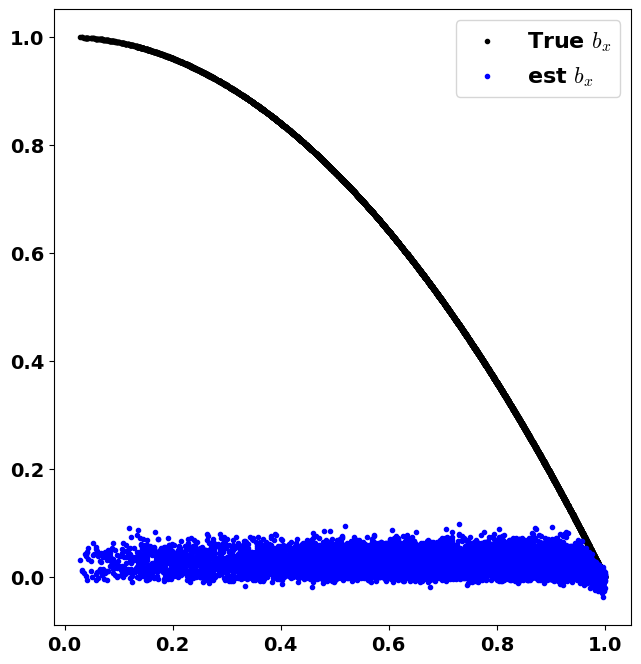

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')
plt.axis('image')
plt.legend()

In [26]:
np.linalg.norm(bx - ddX) / np.linalg.norm(ddX)

0.9586573521640283